# Chapter 13
## Section: Graph neural networks using PyTorch Geometric

In [ ]:
!pip install torch_geometric

Adapted from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=afXwPCA3KNoC

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
data = dataset[0]  # Get the first graph object.
print('Number of features: {}'.format(dataset.num_features))
print('Number of classes: {}'.format(dataset.num_classes))

Processing...
Done!


Number of features: 3703
Number of classes: 6


In [3]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
torch.manual_seed(123)

class GCNet(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.gcn_layer1 = GCNConv(dataset.num_features, hidden_channels[0])
        self.gcn_layer2 = GCNConv(hidden_channels[0], hidden_channels[1])
        self.gcn_layer3 = GCNConv(hidden_channels[1], dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.gcn_layer1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.gcn_layer2(x, edge_index)
        x = x.relu()
        x = self.gcn_layer3(x, edge_index)

        return x

In [4]:
model = GCNet(hidden_channels=[128, 16])
print(model)

GCNet(
  (gcn_layer1): GCNConv(3703, 128)
  (gcn_layer2): GCNConv(128, 16)
  (gcn_layer3): GCNConv(16, 6)
)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

In [6]:
import numpy as np
import matplotlib.pyplot as plt

epoch_list = []
loss_list = []
for epoch in np.arange(1, 401):
    loss = train()
    if epoch%20 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      epoch_list.append(epoch)
      loss_list.append(loss.detach().numpy())

Epoch: 020, Loss: 0.6274
Epoch: 040, Loss: 0.0815
Epoch: 060, Loss: 0.0550
Epoch: 080, Loss: 0.0375
Epoch: 100, Loss: 0.0348
Epoch: 120, Loss: 0.0256
Epoch: 140, Loss: 0.0280
Epoch: 160, Loss: 0.0226
Epoch: 180, Loss: 0.0217
Epoch: 200, Loss: 0.0171
Epoch: 220, Loss: 0.0171
Epoch: 240, Loss: 0.0175
Epoch: 260, Loss: 0.0169
Epoch: 280, Loss: 0.0135
Epoch: 300, Loss: 0.0118
Epoch: 320, Loss: 0.0139
Epoch: 340, Loss: 0.0160
Epoch: 360, Loss: 0.0106
Epoch: 380, Loss: 0.0105
Epoch: 400, Loss: 0.0097


Text(0, 0.5, 'Loss')

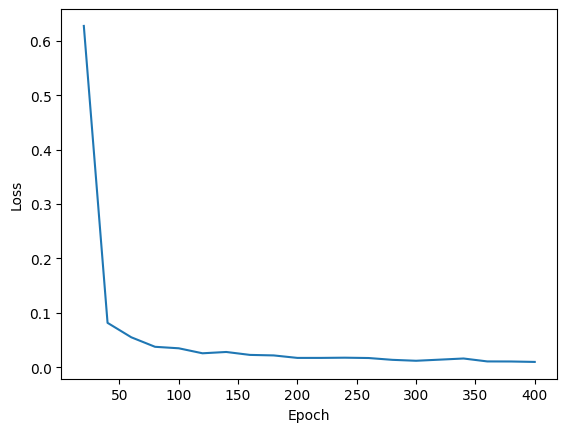

In [7]:
plt.plot(epoch_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [8]:
def test():
      model.eval()
      pred = model(data.x, data.edge_index).argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.3f}')

Test Accuracy: 0.655


In [9]:
model.eval()
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true = data.y, y_pred = model(data.x, data.edge_index).argmax(dim=1))
print(cf)

[[135  31  14  22  42  20]
 [116 321  66  20  43  24]
 [ 27 105 401  98  11  26]
 [ 75  20  47 504  39  16]
 [ 27  21   5  45 462  36]
 [ 42  11  36  29  29 361]]


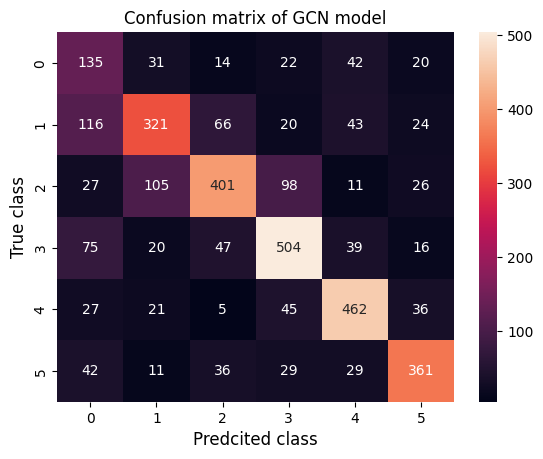

In [10]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, fmt="d") # create seaborn heatmap

plt.title('Confusion matrix of GCN model', fontsize = 12) # title with fontsize 20
plt.xlabel('Predcited class', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('True class', fontsize = 12) # y-axis label with fontsize 15

plt.show()